In [7]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
from PIL import Image

PermissionError: [Errno 1] Operation not permitted

### Week 3: Histopathologic Cancer Detection

#### Problem:
This project involves analyzing medical images and building a good CNN model to identify images showing symptoms of metastatic cancer. The data is sourced from https://www.kaggle.com/c/histopathologic-cancer-detection/overview, which itself is a slightly modified version of the PatchCamelyon dataset (supposedly with duplicates removed). The dataset is fairly large, with about 220,000 images in the training data (and another 57.5k for the test set). The training data comes with labels (for whether there is metastatic cancer).

#### EDA:
Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis? 

Starting with importing the training labels into a dataframe. Label data is pretty straightforward, 220,025 entries, with an id as well as the actual label (0 for no cancer, 1 for with cancer).

In [3]:
label_df = pd.read_csv('histopathologic-cancer-detection/train_labels.csv', dtype=str)
train_image_path = ('histopathologic-cancer-detection/train/')

print(label_df.info())
print(label_df.columns)
label_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  object
dtypes: object(2)
memory usage: 3.4+ MB
None
Index(['id', 'label'], dtype='object')


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


Checking for null values or duplicate rows. The Kaggle mentions duplicates were removed, but want to make sure. Doesn't seem like there's any missing or duplicated values though, so not much to clean.

In [10]:
# Check for null
na_count = label_df.isna().sum()
print("Null count:", na_count)

# Check for dupes
dupes = label_df['id'].duplicated()
print("Duplicate rows: ", dupes.sum())

Null count: id       0
label    0
dtype: int64
Duplicate rows:  0


I want to check the distribution of images labeled 0 and 1 to see if it's imbalanced. Overall, there's more 0s than 1s, but it's not overly imbalanced.

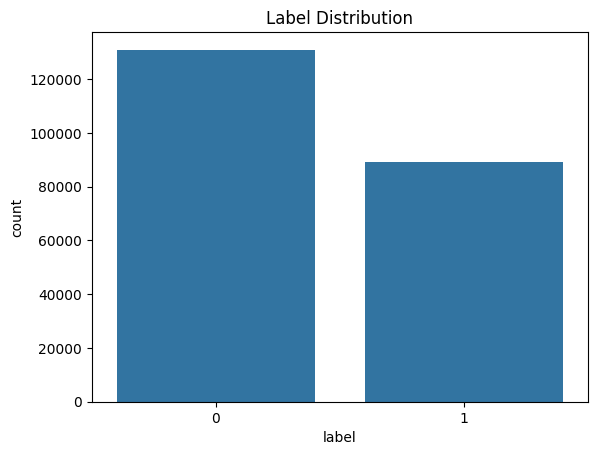

In [12]:
# Draw 0/1 label plot
sns.countplot(x='label', data=label_df)
plt.title('Label Distribution')
plt.show()

Taking a look at some sample images for reference.

In [4]:

#Showing some samples from 0 and 1


#### Model Architecture:
Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters. 

In [ ]:
#Placeholder

#### Results and Analysis
Run hyperparameter tuning, try different architectures for comparison, apply techniques to improve training or performance, and discuss what helped.

Includes results with tables and figures. There is an analysis of why or why not something worked well, troubleshooting, and a hyperparameter optimization procedure summary.

In [ ]:
#Placeholder

#### Conclusion
Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

In [3]:
#placeholder